## Load and Inspect Data




In [1]:
import pandas as pd

# Load 'historical_data.csv'
historical_data_df = pd.read_csv('/content/historical_data.csv')

# Inspect historical_data_df
print('--- historical_data_df Inspection ---')
print(f'Shape of historical_data_df: {historical_data_df.shape}')
print('\nMissing values in historical_data_df:')
print(historical_data_df.isnull().sum())
print(f'\nDuplicate rows in historical_data_df: {historical_data_df.duplicated().sum()}')

# Load 'fear_greed_index.csv'
fear_greed_index_df = pd.read_csv('/content/fear_greed_index.csv')

# Inspect fear_greed_index_df
print('\n--- fear_greed_index_df Inspection ---')
print(f'Shape of fear_greed_index_df: {fear_greed_index_df.shape}')
print('\nMissing values in fear_greed_index_df:')
print(fear_greed_index_df.isnull().sum())
print(f'\nDuplicate rows in fear_greed_index_df: {fear_greed_index_df.duplicated().sum()}')

--- historical_data_df Inspection ---
Shape of historical_data_df: (211224, 16)

Missing values in historical_data_df:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate rows in historical_data_df: 0

--- fear_greed_index_df Inspection ---
Shape of fear_greed_index_df: (2644, 4)

Missing values in fear_greed_index_df:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows in fear_greed_index_df: 0


## Prepare and Align Datasets




In [4]:
import pandas as pd

# 1. Convert 'Timestamp' in historical_data_df to datetime objects and create 'Date' column
historical_data_df['datetime_utc'] = pd.to_datetime(historical_data_df['Timestamp'], unit='ms', utc=True)
historical_data_df['Date'] = historical_data_df['datetime_utc'].dt.date

# 2. Convert 'date' in fear_greed_index_df to datetime objects
fear_greed_index_df['date'] = pd.to_datetime(fear_greed_index_df['date'])

# Ensure 'date' column in fear_greed_index_df is also just dates for consistent merging
fear_greed_index_df['date'] = fear_greed_index_df['date'].dt.date

# 3. Merge the two dataframes
merged_df = pd.merge(historical_data_df, fear_greed_index_df, left_on='Date', right_on='date', how='left')

# 4. Display the first 5 rows and the shape of the merged_df
print('--- merged_df Head ---')
print(merged_df.head())
print('\n--- merged_df Shape ---')
print(f'Shape of merged_df: {merged_df.shape}')

--- merged_df Head ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL  ... Crossed       Fee      Trade ID     Timestamp  \
0         0.0

## Calculate Key Trading Metrics




In [5]:
import numpy as np

# Group by Account and Date to calculate daily metrics
metrics_df = merged_df.groupby(['Account', 'Date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_trades=('Trade ID', 'count'),
    winning_trades=('Closed PnL', lambda x: (x > 0).sum()),
    avg_trade_size_usd=('Size USD', 'mean'),
    long_trades=('Direction', lambda x: (x == 'Buy').sum()),
    short_trades=('Direction', lambda x: (x == 'Sell').sum())
).reset_index()

# Calculate win_rate, handling division by zero
metrics_df['win_rate'] = np.where(
    metrics_df['total_trades'] > 0,
    metrics_df['winning_trades'] / metrics_df['total_trades'],
    0
)

# Calculate long_short_ratio, handling division by zero/NaN
metrics_df['long_short_ratio'] = np.where(
    metrics_df['short_trades'] > 0,
    metrics_df['long_trades'] / metrics_df['short_trades'],
    np.where(metrics_df['long_trades'] > 0, np.inf, 0) # If long trades exist but no short, ratio is inf; if neither, ratio is 0
)

# Fill any remaining NaN values (e.g., if a trader had no activity on a given day) with 0
metrics_df = metrics_df.fillna(0)

# Display the first 5 rows and the shape of the metrics_df
print('--- metrics_df Head ---')
print(metrics_df.head())
print('\n--- metrics_df Shape ---')
print(f'Shape of metrics_df: {metrics_df.shape}')

--- metrics_df Head ---
                                      Account        Date     daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-10-27 -3.275059e+05   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-02-19  1.927736e+06   
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  2024-10-27  2.060745e+04   
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  2025-02-19  1.709873e+04   
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  2025-06-15  1.017915e+04   

   total_trades  winning_trades  avg_trade_size_usd  long_trades  \
0           462              12        14810.891818            0   
1          3356            1361        16345.241940            0   
2           320             170         2492.749906          132   
3          3533            1537         1693.351684         1204   
4          3427            1516         1533.468395          604   

   short_trades  win_rate  long_short_ratio  
0             0  0.025974          0.000000  
1             0  0.40554

## Analyze Performance by Sentiment




In [6]:
import pandas as pd

# 1. Merge metrics_df with fear_greed_index_df on date columns
sentiment_performance_df = pd.merge(metrics_df,
                                   fear_greed_index_df[['date', 'classification']],
                                   left_on='Date', right_on='date', how='left')

# 2. Filter for 'Fear' and 'Greed' days
sentiment_performance_filtered_df = sentiment_performance_df[
    sentiment_performance_df['classification'].isin(['Fear', 'Greed'])
].copy()

# 3. Group by classification and calculate the mean of 'daily_pnl' and 'win_rate'
sentiment_summary = sentiment_performance_filtered_df.groupby('classification').agg(
    average_daily_pnl=('daily_pnl', 'mean'),
    average_win_rate=('win_rate', 'mean')
).reset_index()

print('--- Sentiment Performance Summary ---')
print(sentiment_summary)

--- Sentiment Performance Summary ---
  classification  average_daily_pnl  average_win_rate
0           Fear      209372.662205          0.415878
1          Greed       99675.516731          0.374074


**Reasoning**:
Now that the sentiment summary is computed, I will create two bar charts to visualize the average daily PnL and average win rate for 'Fear' and 'Greed' days, as requested by the subtask.



/tmp/ipython-input-2385893353.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='average_daily_pnl', data=sentiment_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'})


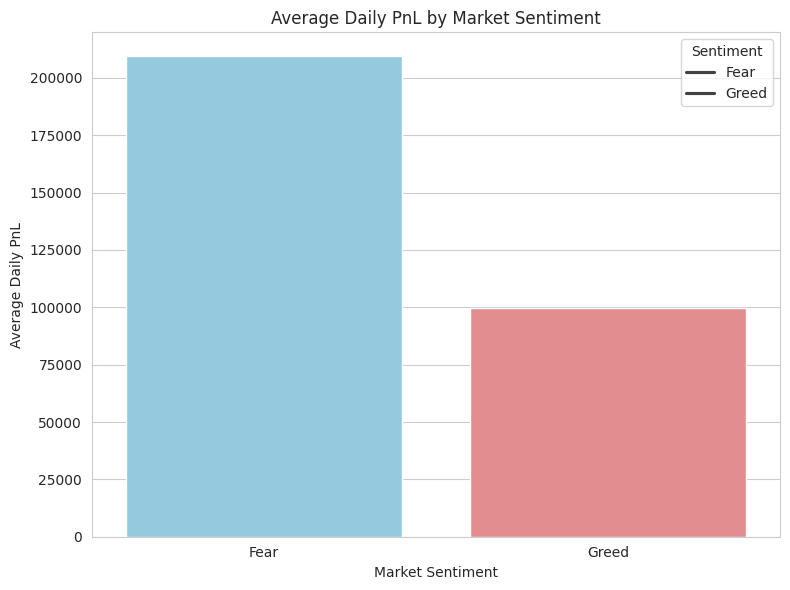

/tmp/ipython-input-2385893353.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='average_win_rate', data=sentiment_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'})


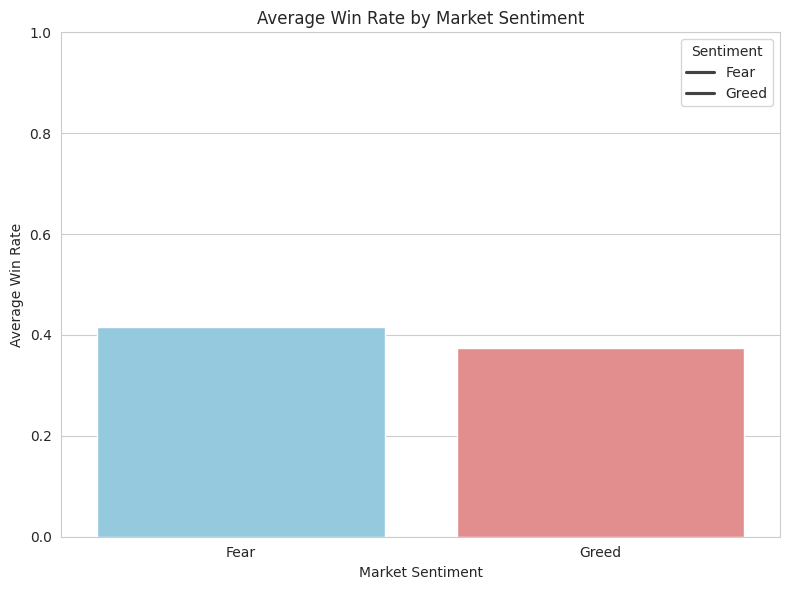

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style('whitegrid')

# 4. Create a bar chart for average daily PnL
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_daily_pnl', data=sentiment_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'})
plt.title('Average Daily PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Daily PnL')
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

# 5. Create a bar chart for average win rate
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_win_rate', data=sentiment_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'})
plt.title('Average Win Rate by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Win Rate')
plt.ylim(0, 1) # Win rate is between 0 and 1
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

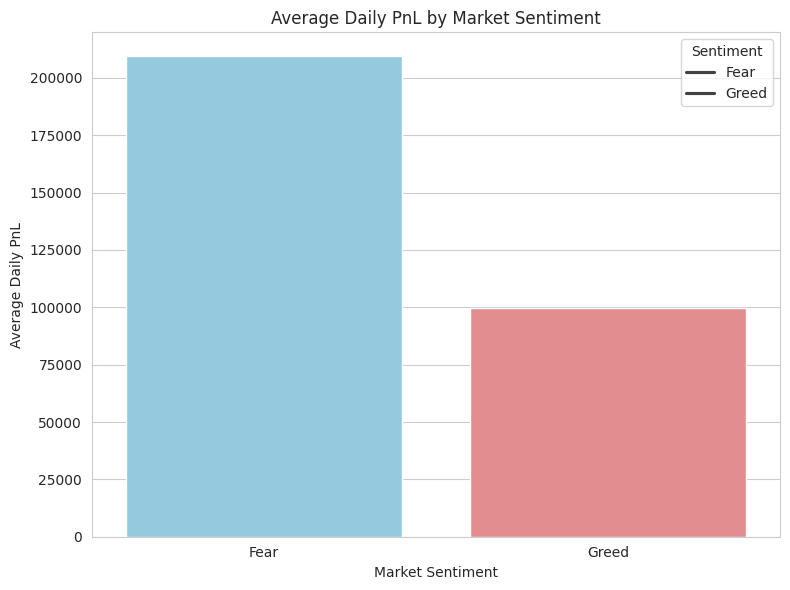

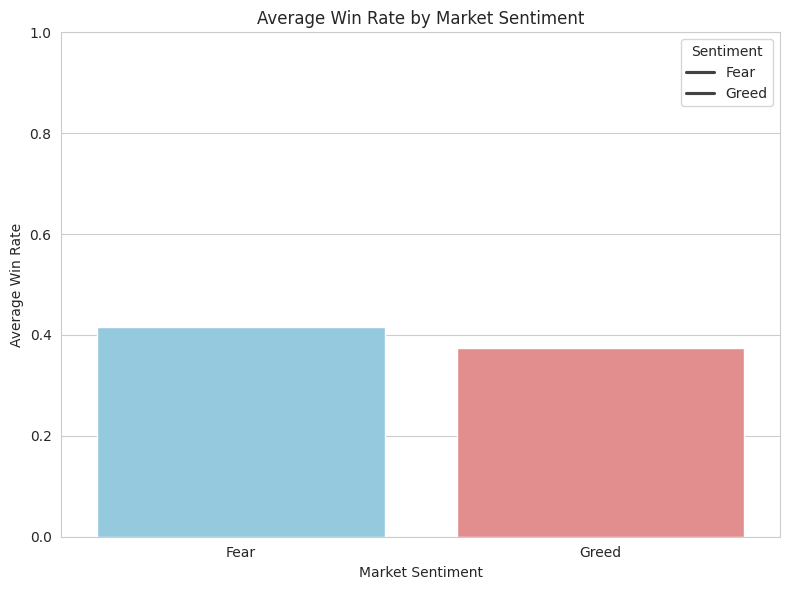

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style('whitegrid')

# 4. Create a bar chart for average daily PnL
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_daily_pnl', hue='classification', data=sentiment_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'}, legend=False)
plt.title('Average Daily PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Daily PnL')
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

# 5. Create a bar chart for average win rate
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_win_rate', hue='classification', data=sentiment_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'}, legend=False)
plt.title('Average Win Rate by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Win Rate')
plt.ylim(0, 1) # Win rate is between 0 and 1
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

## Analyze Trader Behavior by Sentiment




In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Group by classification and calculate the mean of 'total_trades', 'avg_trade_size_usd', and 'long_short_ratio'
sentiment_behavior_summary = sentiment_performance_filtered_df.groupby('classification').agg(
    average_total_trades=('total_trades', 'mean'),
    average_position_size=('avg_trade_size_usd', 'mean'),
    average_long_short_ratio=('long_short_ratio', 'mean')
).reset_index()

# 2. Print the resulting summary DataFrame
print('--- Sentiment Behavior Summary ---')
print(sentiment_behavior_summary)

--- Sentiment Behavior Summary ---
  classification  average_total_trades  average_position_size  \
0           Fear            4183.46875            5926.522723   
1          Greed            1134.03125            5839.310974   

   average_long_short_ratio  
0                       inf  
1                       inf  


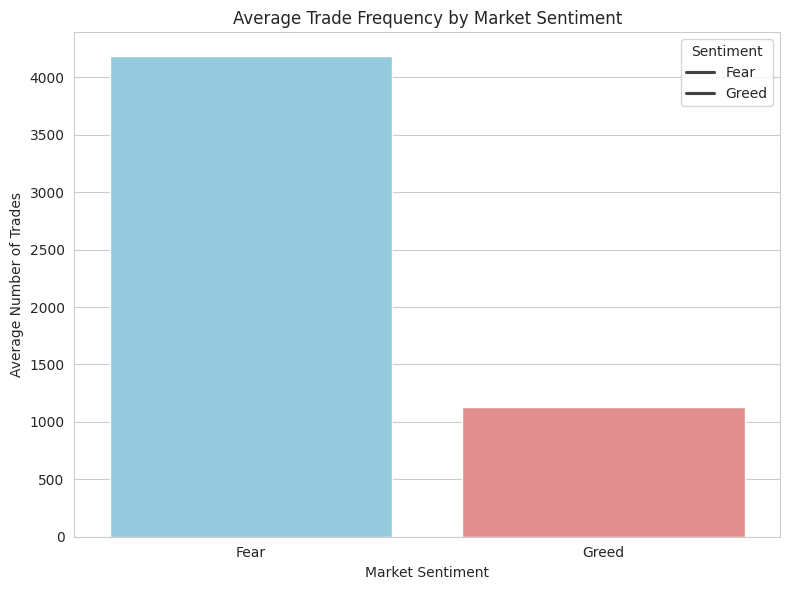

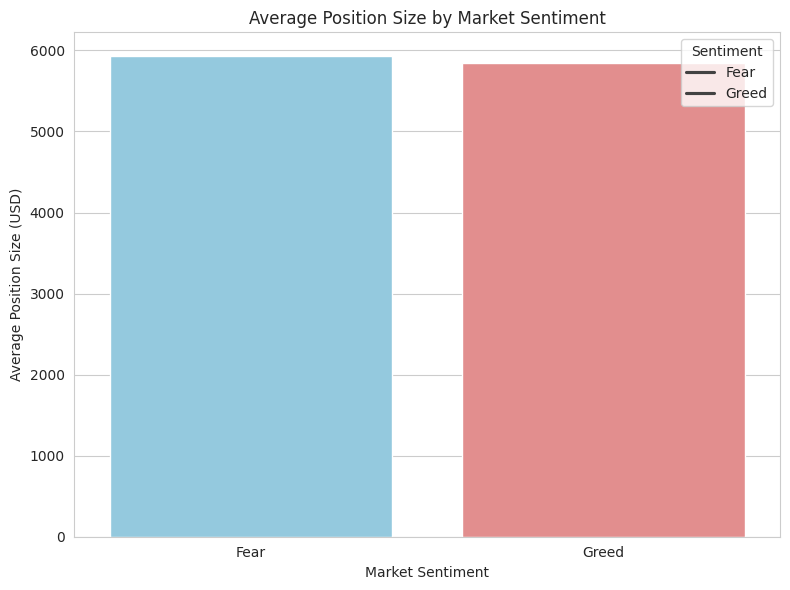

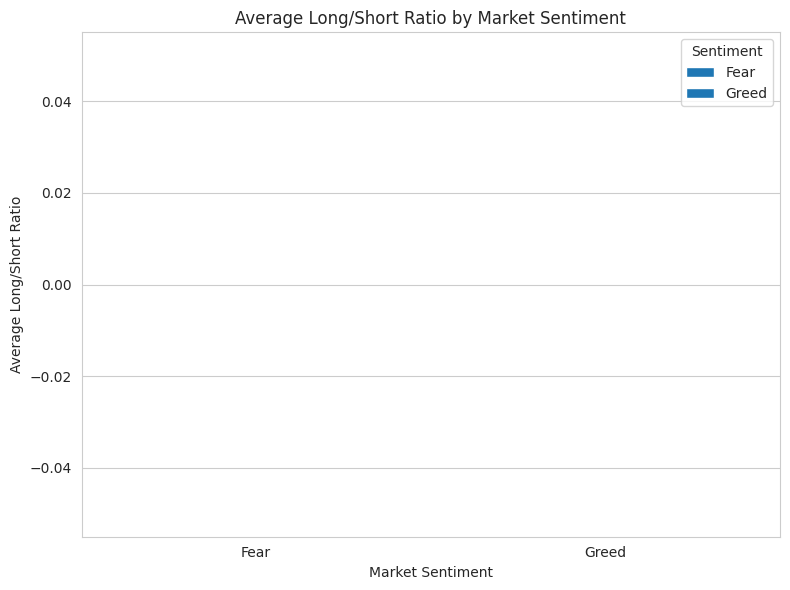

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# 4. Create a bar chart for average total trades
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_total_trades', hue='classification', data=sentiment_behavior_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'}, legend=False)
plt.title('Average Trade Frequency by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Number of Trades')
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

# 5. Create a bar chart for average position size
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_position_size', hue='classification', data=sentiment_behavior_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'}, legend=False)
plt.title('Average Position Size by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Position Size (USD)')
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

# 6. Create a bar chart for average long/short ratio
plt.figure(figsize=(8, 6))
sns.barplot(x='classification', y='average_long_short_ratio', hue='classification', data=sentiment_behavior_summary, palette={'Fear': 'skyblue', 'Greed': 'lightcoral'}, legend=False)
plt.title('Average Long/Short Ratio by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Long/Short Ratio')
plt.legend(title='Sentiment', labels=['Fear', 'Greed'])
plt.tight_layout()
plt.show()

## Segment Traders




In [11]:
import numpy as np

# 1. Aggregate metrics_df by 'Account' to calculate overall performance and behavior metrics
trader_segments_df = metrics_df.groupby('Account').agg(
    total_pnl=('daily_pnl', 'sum'),
    avg_win_rate=('win_rate', 'mean'),
    total_trades=('total_trades', 'sum')
).reset_index()

# Calculate medians for segmentation criteria
median_total_trades = trader_segments_df['total_trades'].median()
median_avg_win_rate = trader_segments_df['avg_win_rate'].median()

# 2. Define and apply trader segments
# Profitability
trader_segments_df['profitability_segment'] = np.where(
    trader_segments_df['total_pnl'] > 0, 'Profitable', 'Unprofitable'
)

# Trading Frequency
trader_segments_df['frequency_segment'] = np.where(
    trader_segments_df['total_trades'] > median_total_trades, 'High Frequency', 'Low Frequency'
)

# Win Rate Performance
trader_segments_df['win_rate_segment'] = np.where(
    trader_segments_df['avg_win_rate'] > median_avg_win_rate, 'High Win Rate', 'Low Win Rate'
)

# 4. Display the count of traders in each segment
print('--- Trader Segmentation Counts ---')
print('\nProfitability Segment Counts:')
print(trader_segments_df['profitability_segment'].value_counts())

print('\nTrading Frequency Segment Counts:')
print(trader_segments_df['frequency_segment'].value_counts())

print('\nWin Rate Performance Segment Counts:')
print(trader_segments_df['win_rate_segment'].value_counts())

# 5. Display the first few rows of the aggregated DataFrame with new segment classifications
print('\n--- Trader Segments DataFrame Head ---')
print(trader_segments_df.head())

--- Trader Segmentation Counts ---

Profitability Segment Counts:
profitability_segment
Profitable      29
Unprofitable     3
Name: count, dtype: int64

Trading Frequency Segment Counts:
frequency_segment
High Frequency    16
Low Frequency     16
Name: count, dtype: int64

Win Rate Performance Segment Counts:
win_rate_segment
Low Win Rate     16
High Win Rate    16
Name: count, dtype: int64

--- Trader Segments DataFrame Head ---
                                      Account     total_pnl  avg_win_rate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06      0.215758   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  4.788532e+04      0.469553   
2  0x271b280974205ca63b716753467d5a371de622ab -7.043619e+04      0.369293   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  1.324648e+05      0.484757   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd  1.686580e+05      0.536078   

   total_trades profitability_segment frequency_segment win_rate_segment  
0          3818            P